In [158]:
import numpy as np
import matplotlib.pyplot as plt 
import wave
from scipy.io import wavfile
import IPython.display as ipd
from IPython.display import display,Audio

# **Découpage en trames de 20 ms**

8000


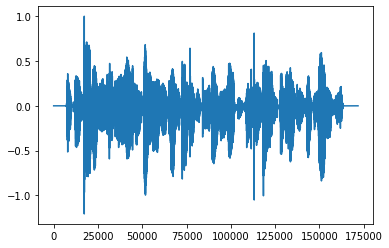

In [159]:
#Découper le fichier en trames de 20 ms

samplerate, data = wavfile.read('sound.wav')
Fe=8000
print(Fe)

#data = data.sum(axis=1) / 2
data=data+0.00000000001


display(Audio(data,rate=samplerate))
#durée du signal sonore en secondes
T=len(data)/Fe
#Nombre d'échantillons dans chaque trame
n=int(20*10**(-3)*Fe)
#Découpage en trames
y,i,l=[],0,0
data=np.array(data)/max(data)
plt.plot(data)
while (l!=len(data)):
  l=min(n+i*n,len(data))
  y.append(data[0+i*n:l])
  i+=1
#On a 320 échantillons par trames 


# **Méthode LPC**

In [160]:
#LPC pour chaque trame

#Calcule des coefficients R(p)
def R(j,p):   #j représente le numéro de la trame, cette fonction calcule le coeff R(p) de la j ème trame
  r=0
  N=len(y[j])-p
  for i in range(N):
    r+=y[j][i]*y[j][i+p]
  return r

def LPC (j,P):       #Résoudre A*a=r, j représente le numéro de la trame
  r=np.zeros((P, 1))
  for i in range (P):
    r[i][0]=R(j,i+1)
  
  A=np.zeros((P, P))
  for i in range (P):
    #Valeurs sur la diagonale
    A[i][i] = R(j,0)
  #Valeurs au dessus de la diagonale 
  for i in range (P):
    for k in range (P):
      if (i+k<P):
        #A[0+k][i+k] = A[0][i]
        A[0+k][i+k] = R(j,i)      
  #Ensuite pour toute valeur de la matrice en dessous de la diagonale faire = à son symétrique
  for i in range (P):
    for k in range (P):
      if(i+k<P):
        A[i+k][k] = A[k][i+k]
  return A,r

In [161]:
def e(i,n):  #n 
  e=np.zeros((n,1))
  e[i-1]=1
  return e

def Durbin(P):
  #f,b=1/R(200,0),1/R(200,0)
  #f=np.array([1/R(200,0)])
  f=np.array([1/R(200,0)])  #Forward
  b=np.array([1/R(200,0)])  #Backward
  n=0
  A,r=LPC(200,P)
  while(n<P-2):
    eps_f,eps_b=0,0
    #for i in range (len(f)):
      #eps_f+=A[-1][i]*f[i]
      
    for i in range (1,len(b)):
      eps_b+=A[0][i+1]*b[i]
    f,b=(np.insert(f,len(f),0)-eps_f*np.insert(b,0,0)) /(1-eps_b*eps_f),(np.insert(b,0,0)-eps_b*np.insert(f,len(f),0)) /(1-eps_b*eps_f) 
    n+=1
  #f,b=list(f,b)
  #f,b=np.reshape(f, (n, 1)),np.reshape(b, (n, 1))
  return f,b

In [162]:

#print(x)

# **Tracé du filtre du conduit vocal**

In [163]:
def H(z):
  P=len(x)
  den=0
  for i in range(P):
    den+=x[i]*z**(-i-1)
    
  return 1/(1-den)

def Hf(f):
    return H(np.exp(1j*2*math.pi*f))

In [164]:
a,b=LPC(200,8)
i= np.linalg.inv(a)
x=np.dot(i,b)

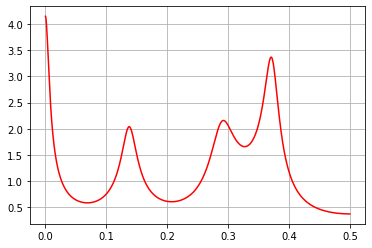

In [165]:
import math
import cmath
f = np.arange(start=0,stop=0.5,step=0.000125)
plt.plot(f,np.absolute(Hf(f)),'r')
plt.grid()
plt.show()



In [166]:
def Y(z):
  N=len(y[215])
  s=0
  for i in range (N):
    s+=y[215][i]*z**(-i-1)
  return s

def Yf(f):
  return  Y(np.exp(1j*2*math.pi*f))

def e(z):
  return Y(z)/H(z)

def ef(f):
  return e(np.exp(1j*2*math.pi*f/Fe))

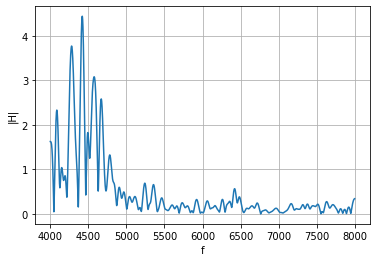

In [167]:
f = np.arange(start=Fe/2,stop=Fe,step=1)

plt.plot(f,np.absolute(ef(f)))
plt.xlabel('f')
plt.ylabel('|H|')
plt.grid()

# **Extraire la fréquence fondamentale**

In [168]:
def frequence(ef):
      freqs = np.fft.fftfreq(len(ef(f)))
      #print(freqs.min(),freqs.max())
      idx = np.argmax(np.abs(ef(f)))
      #print(idx)
      freq = freqs[idx]
      freq_in_hertz = abs(freq * Fe)
      return freq_in_hertz
freq_in_hertz=frequence(ef)
print(freq_in_hertz)

840.0


In [169]:
## calcule de la oopuissance de la source 
print(b)

[[-0.05402388]
 [-0.07051665]
 [ 0.34036076]
 [-0.16016873]
 [ 0.06711278]
 [ 0.19982388]
 [ 0.06613962]
 [ 0.24558132]]


160


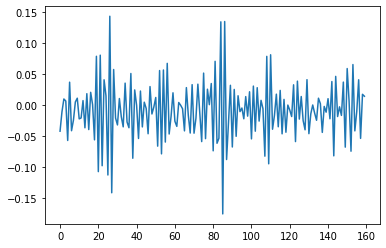

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/IPython/lib/display.py:123: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


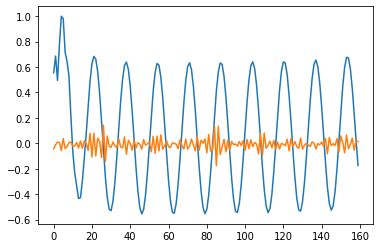

840.0
830.6093951598907


In [170]:
def get_note(frequance ):
    k=2**(1/12)
    la3=440 #reference 
    
    x=round((math.log(frequance+0.000001)-math.log(la3))/math.log(k))
    # notelist=["do or si#","do♯ ou ré♭","ré","ré♯ ou mi♭	","mi ou fa♭","fa ou mi♯","fa♯ ou sol♭","sol","sol♯ ou la♭","la","la♯ ou si♭","si ou do♭"]
    # temp=9
    # index=temp+x
    # print( index)
    # for i  in in range(84)
    #     if index<0:
    #         index=11
    #     elif index>11:
    #         index=0
   
    # note=notelist[index]
    
    # prin
    freq= la3*k**(x)
    return (freq)

new_f= get_note(freq_in_hertz )
f = np.arange(start=0,stop=0.5,step=1/320)
N=len(y[200])
print(N)

te=np.linspace(0,N/new_f,N)

sing=np.sin(2. * np.pi *te/0.02)

singfft=np.fft.fft(sing)

plt.plot(y[215])
new_exit=singfft*(Hf(f))
audio=np.fft.ifft((new_exit))
audio=audio/max(audio)
plt.show()
plt.plot(audio)
plt.plot(y[215])

display(Audio(audio,rate=samplerate))
display(Audio(y[215],rate=samplerate))
plt.show()
print(freq_in_hertz)
print(new_f)


[]

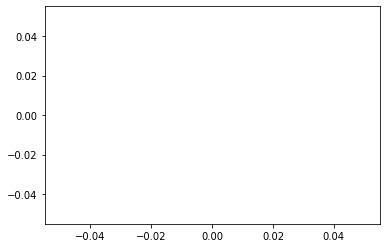

In [171]:
plt.plot()

In [172]:
print(new_f)
print(len(x))
#print(Hf(f))
print(freq_in_hertz)

830.6093951598907
8
840.0


In [173]:
######################### main ##################################
        #################################################
   
ordre=5
signal=[]
print(len(y))
for i in range(len(y)):
    A,b=LPC(i,ordre)
    Rinv= np.linalg.inv(A)
    x=np.dot(Rinv,b)
    f = np.arange(start=0,stop=0.5,step=1/(2*len(y[i])))
    freq_in_hertz=frequence(ef)
    new_f= get_note(freq_in_hertz)
    N=len(y[i])
    te=np.linspace(0,(N-1)/new_f,N)

    sing=np.sin(2. * np.pi *te/0.02)
    singfft=np.fft.fft(sing)
    new_exit=singfft*np.absolute(Hf(f))
    audio=np.fft.ifft(new_exit)
    signal.extend(audio)

signal=np.real(signal)


1074


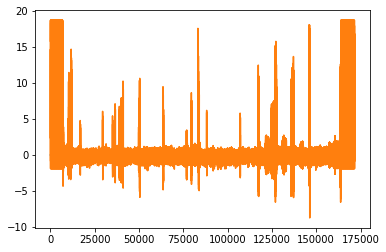

In [174]:
plt.plot(data)
plt.plot(signal)

display(Audio(signal,rate=samplerate))

In [175]:
def sigma(trame):
  for i in range l

SyntaxError: ignored